# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of service requests generated: 15
H {'03612_2024-06-25-17.40': {'60000': [1060, 1060], '71801': [1210, 1210]}, '02731_2024-06-25-13.32': {'60000': [812, 812], '04040': [887, 889], '71500': [962, 964], '71801': [997, 997]}, '03612_2024-06-25-21.27': {'60000': [1287, 1287], '71801': [1437, 1437]}, '02731_2024-06-25-17.27': {'60000': [1047, 1047], '04040': [1122, 1124], '71500': [1197, 1199], '71801': [1232, 1232]}, '02731_2024-06-25-15.44': {'60000': [944, 944], '04040': [1019, 1021], '71500': [1094, 1096], '71801': [1129, 1129]}, '03612_2024-06-25-18.05': {'60000': [1085, 1085], '71801': [1235, 1235]}, '03612_2024-06-25-18.25': {'60000': [1105, 1105], '71801': [1255, 1255]}, '04161_2024-06-25-13.52': {'60000': [832, 832], '70600': [887, 888], '04040': [913, 914], '78400': [957, 959], '71500': [986, 988], '71801': [1024, 1024]}, '03612_2024-06-25-22.57': {'60000': [1377, 1377], '71801': [1527, 1527]}, '03612_2024-06-25-19.12': {'60000': [1152, 1152], '71801': [1302, 1302]}, '03612

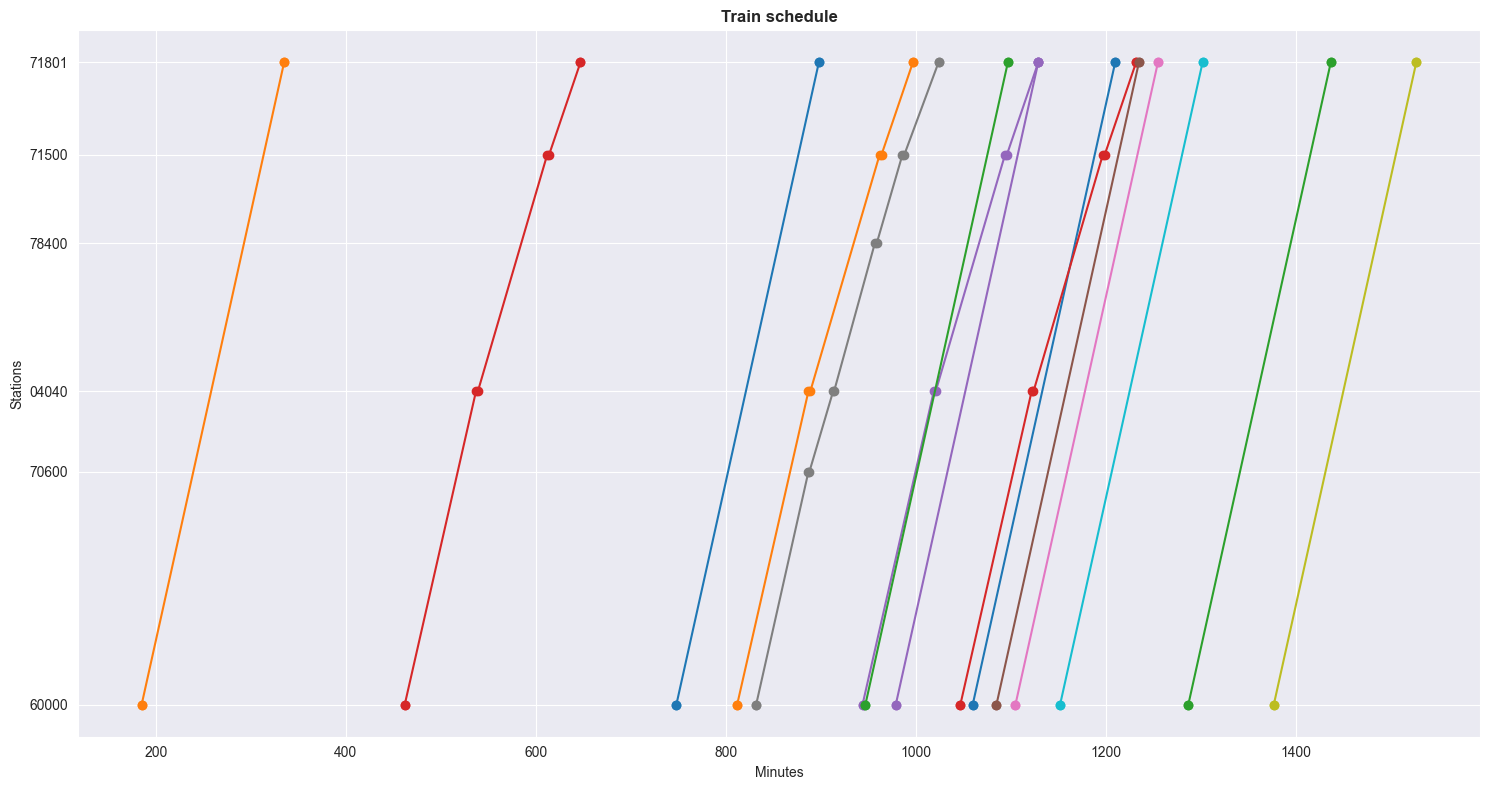

  0%|          | 0/11 [00:00<?, ?it/s]

Elapsed time: 2.0 seconds
Elapsed time: 2.0 seconds
Elapsed time: 2.07 seconds
Elapsed time: 1.99 seconds
Elapsed time: 2.03 seconds
Elapsed time: 2.03 seconds
Elapsed time: 2.01 seconds
Elapsed time: 2.01 seconds
Elapsed time: 2.02 seconds
Elapsed time: 2.01 seconds
Elapsed time: 2.04 seconds


,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.)
4,5.0,2339.074613,2.000245,11.0,2.0,13.0
1,2.0,2318.633679,1.972955,11.0,2.0,16.0
5,6.0,2316.609617,2.006295,11.0,0.0,20.0
10,11.0,2313.030836,2.010615,11.0,7.0,17.0
3,4.0,2312.315503,1.963531,11.0,6.0,14.0
8,9.0,2293.504826,1.992719,11.0,1.0,23.0
7,8.0,2291.679853,1.984619,11.0,11.0,8.0
9,10.0,2289.188600,1.985048,11.0,7.0,21.0
6,7.0,2287.990265,1.985395,11.0,8.0,23.0
0,1.0,2277.372583,1.976051,11.0,5.0,24.0


Global GSA status:
	Total execution time: 21.9177 s.
	Execution Time (by run) - Mean: 1.9925 s. - Std: 0.0212 s.
	Revenue - Mean: 2299.3204 - Std: 23.5545
	Scheduled Trains - Mean: 11.0 - Std: 0.0
	Median solution: Run 9
	Max Revenue: 2959.0 - WARNING!: Scheduling all services could not be feasible


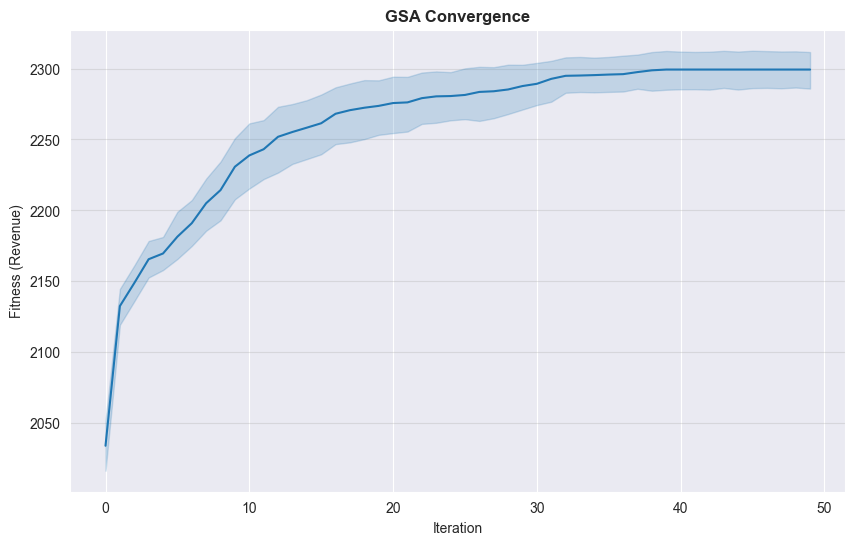

{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '04040', '71500', '71801'])
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '71801'])
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '04040', '71500', '71801'])
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '04040', '71500', '71801'])
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '71801'])
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '70600', '04040', '78400', '71500', '71801'])
{'60000': 0.0, '70600': 362.39, '04040': 487.76, '78400': 718.65, '71500': 856.33, '71801': 1000.0} dict_keys(['60000', '71801'])


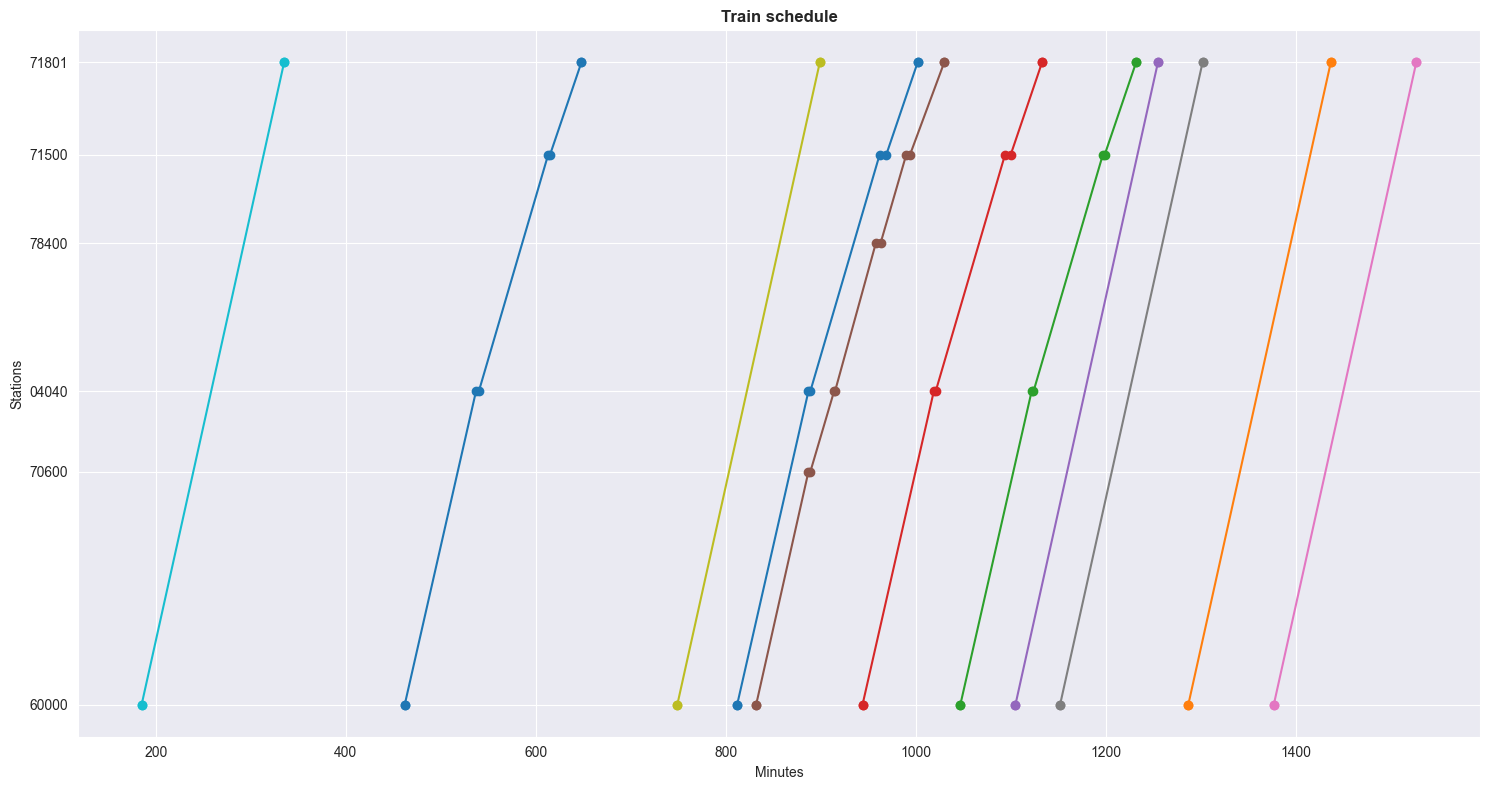

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 4016
	Status: User bought a service which was not the one with the best utility. - Passengers: 3115
	Status: User bought the ticket with best utility. - Passengers: 914
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4029
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 400 - Percentage: 9.93 %
		Seat: Turista - Passengers: 3329 - Percentage: 82.63 %
		Seat: Turista Plus - Passengers: 300 - Percentage: 7.45 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4029
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Turista - Number of tickets sold: 148
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 23
			Seat: Turista - Number of tickets sold: 119
		Date: 2023-06-13
			Seat: Premium - Number of tickets sold: 27
			Seat: Turista

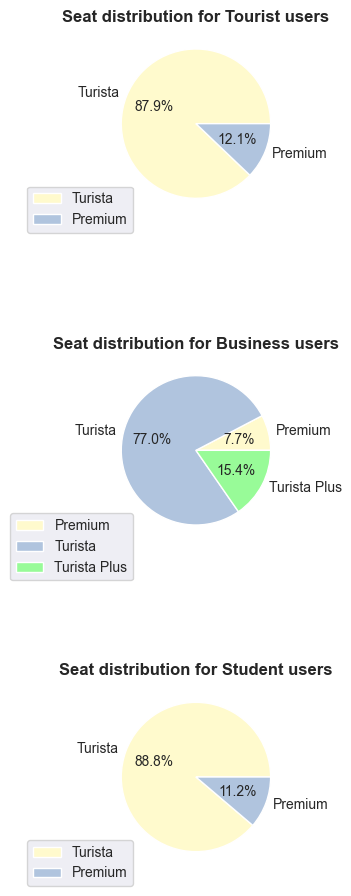

In [14]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path=generator_save_path,
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=f'{robin_save_path}output.yml',
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=11,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [10]:
from robin.demand.entities import Demand

demand = Demand.from_yaml('../configs/demand/demand.yml')

In [11]:
passengers = demand.generate_passengers()

In [12]:
p = passengers[0]

In [19]:
values = [float(rule.split(' ')[-1]) for r, rule in p.user_pattern._rules.items()]
values

[30.0, 40.0, 30.0]

In [44]:
import random

def update_rules(values: list, max_change: int=2):
    for _ in range(len(values)):
        # Set two random indexes
        idx1, idx2 = random.sample(range(len(values)), 2)
        
        # Calculate the amount of change
        cambio = np.round(random.uniform(1, min(max_change, values[idx1], values[idx2])))
        
        # Adjust the values
        values[idx1] -= cambio
        values[idx2] += cambio    
    return values

# Original
original = [30.0, 40.0, 30.0]

updated = update_rules(original.copy())
updated

[29.0, 37.0, 34.0]

100.0


{'MAD': 0.0, 'ZAR': 420.03, 'BAR': 816.44, 'FIG': 1000.0}
{'MAD': 0.0, 'ZAR': 420.03, 'BAR': 816.44, 'FIG': 1000.0} dict_keys(['MAD', 'ZAR', 'BAR'])
{'MAD': 0.0, 'ZAR': 420.03, 'BAR': 816.44, 'FIG': 1000.0} dict_keys(['MAD', 'BAR'])
{'MAD': 0.0, 'ZAR': 420.03, 'BAR': 816.44, 'FIG': 1000.0} dict_keys(['MAD', 'BAR'])


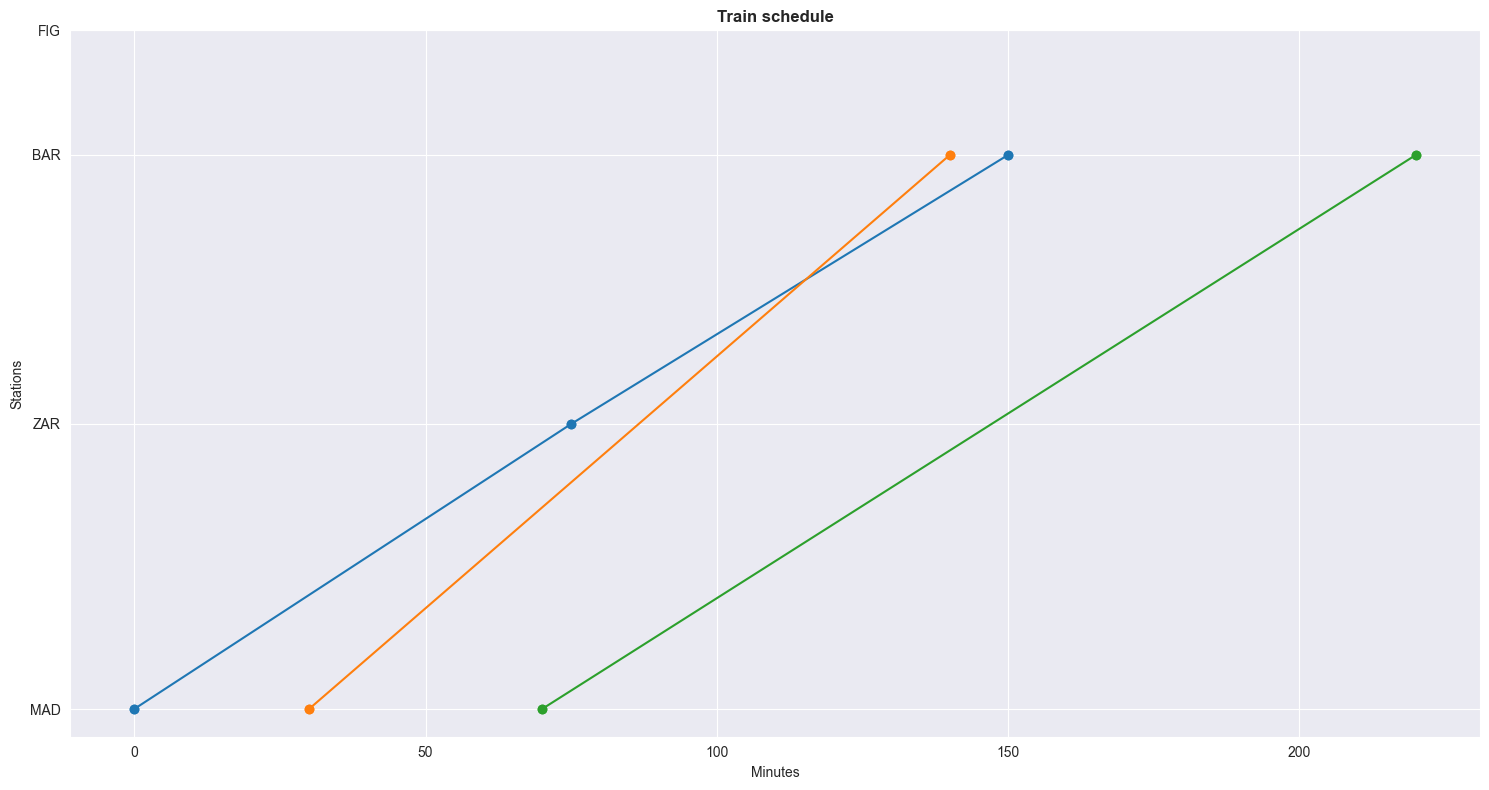

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


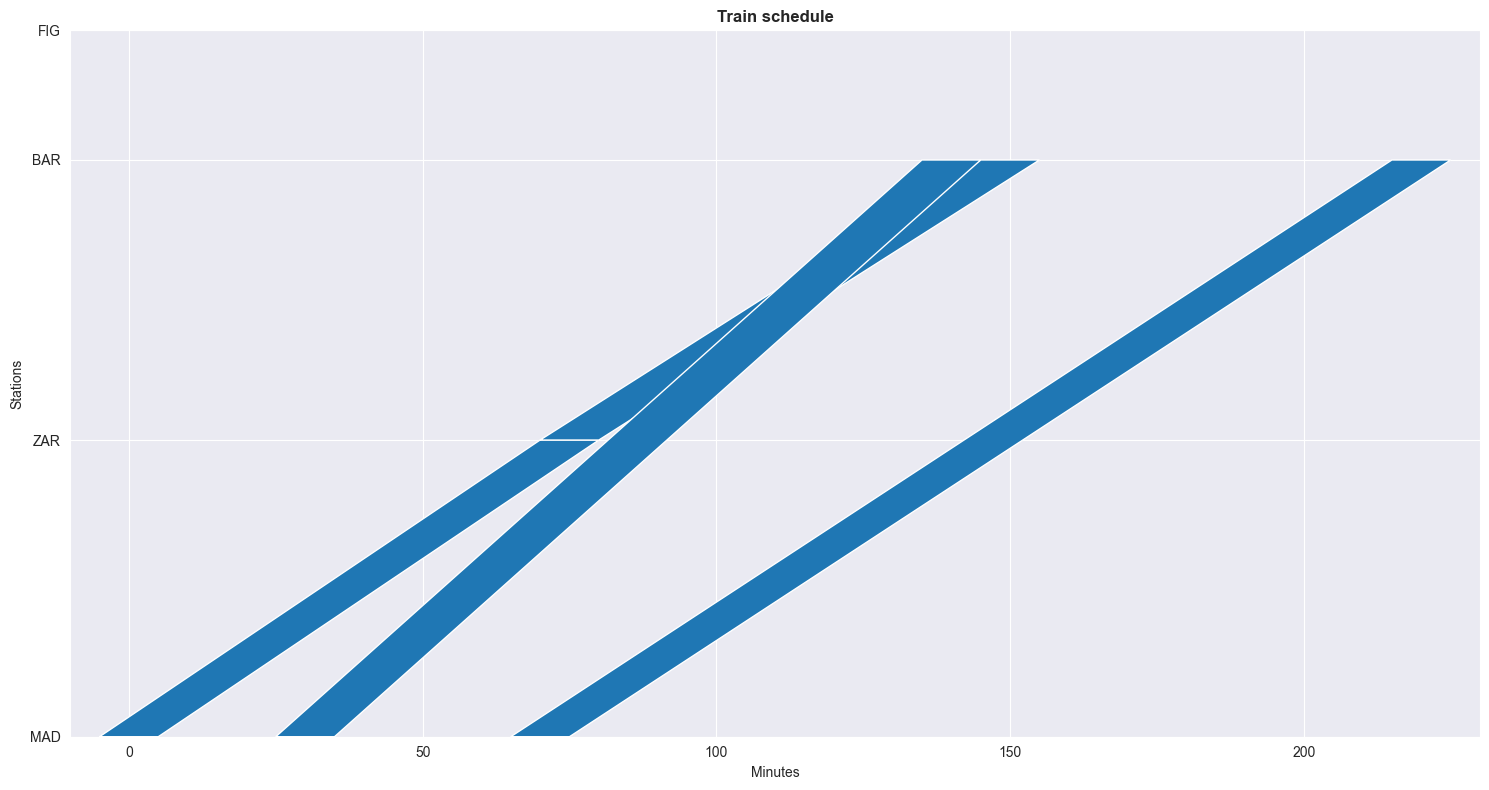

In [20]:
from benchmarks.utils import TrainSchedulePlotter

schedule = {0: {'MAD': (0, 0), 'ZAR': (75, 75), 'BAR': (150, 150)},
            1: {'MAD': (30, 30), 'BAR': (140, 140)},
            2: {'MAD': (70, 70), 'BAR': (220, 220)}
            }

line = {'MAD': (40.406442, -3.690886),
        'ZAR': (41.658649, -0.911615),
        'BAR': (41.37922, 2.140624),
        'FIG': (42.264771, 2.943547)}

schedule_plotter = TrainSchedulePlotter(schedule, line)
print(schedule_plotter.station_positions)
schedule_plotter.plot()
schedule_plotter.plot_security_gaps()

In [29]:
from benchmarks.utils import get_stations_positions

from numpy import ones,vstack
from numpy.linalg import lstsq

def get_closest_station(station, line_stations, other_service_stations):
    """
    GET first station of other_service_stations before station, based on line_stations
    
    Args:
        station: 
        line_stations: 
        other_service_stations: 

    Returns:
        
    """
    list_stations = tuple(line_stations.keys())
    for s in list_stations[:list_stations.index(station)][::-1]:
        if s in other_service_stations:
            return s
    return None


def get_x_line_equation(points):
    x_coords, y_coords = zip(*points)
    K = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(K, y_coords, rcond=None)[0]
    # print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return lambda y: (y - c)/m


conflict_matrix = np.zeros((len(schedule), len(schedule)), dtype=np.bool_)

line_stations = get_stations_positions(line)

security_gap = 10
train_gap = np.ceil(security_gap // 2)
for i, service in enumerate(schedule):
    print(f"Service {service}, {i}")
    service_stations = tuple(schedule[service].keys())
    for k, station in enumerate(service_stations):
        if k == len(service_stations) - 1:
            break
        
        departure_station = station
        arrival_station = service_stations[k + 1]
        print(f"Departure: {departure_station}, Arrival: {arrival_station}")
        departure_time = schedule[service][station][1]
        arrival_time = schedule[service][service_stations[k + 1]][0]
        
        for j, other_service in enumerate(tuple(schedule.keys())[i+1:], start=i+1):
            print(f"Other service {other_service} {j}")
            if other_service == service:
                continue
            other_service_stations = tuple(schedule[other_service].keys())
            if station in other_service_stations:
                other_service_init = station
            else:
                other_service_init = get_closest_station(station, line_stations, other_service_stations)
                
            if not other_service_init:
                continue
                
            print(f"Other service init: {other_service_init}")
            if other_service_init == other_service_stations[-1] or line_stations[other_service_init] >= line_stations[service_stations[k + 1]]:
                continue
            
            print("H")
            other_service_end = other_service_stations[other_service_stations.index(other_service_init) + 1]
            points_other = [(schedule[other_service][other_service_init][1], line_stations[other_service_init]),
                         (schedule[other_service][other_service_end][0], line_stations[other_service_end])]
            
            print(f"Other service init: {other_service_init}, end: {other_service_end}")
            line_other = get_x_line_equation(points_other)
            other_departure_time = line_other(line_stations[departure_station])
            other_arrival_time = line_other(line_stations[arrival_station])
            
            dt_gap = other_departure_time - departure_time
            at_gap = other_arrival_time - arrival_time
            
            same_sign = lambda x, y: x * y > 0
            if same_sign(dt_gap, at_gap) and all(abs(t) >= security_gap for t in (dt_gap, at_gap)):
                continue 
            else:
                conflict_matrix[i, j] = True
                conflict_matrix[j, i] = True
                print(f"Conflict between {service} and {other_service}")
                
print(conflict_matrix)

Service 0, 0
Departure: MAD, Arrival: ZAR
Other service 1 1
Other service init: MAD
H
Other service init: MAD, end: BAR
Other service 2 2
Other service init: MAD
H
Other service init: MAD, end: BAR
Departure: ZAR, Arrival: BAR
Other service 1 1
Other service init: MAD
H
Other service init: MAD, end: BAR
Conflict between 0 and 1
Other service 2 2
Other service init: MAD
H
Other service init: MAD, end: BAR
Service 1, 1
Departure: MAD, Arrival: BAR
Other service 2 2
Other service init: MAD
H
Other service init: MAD, end: BAR
Service 2, 2
Departure: MAD, Arrival: BAR
[[False  True False]
 [ True False False]
 [False False False]]


In [55]:
S_i = np.array([True, True, True], dtype=np.bool_)

new_matrix = S_i * conflict_matrix
new_matrix

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [56]:
filtered_matrix = new_matrix[S_i]
filtered_matrix

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [57]:
np.any(filtered_matrix)

True

In [58]:
np.any((S_i * conflict_matrix)[S_i])

True

In [59]:
np.array([(~cm).all() for cm in conflict_matrix], dtype=np.bool_)

array([False,  True, False])

In [66]:
indexer = {s: i for i, s in enumerate(schedule)}

s = 0
np.where(conflict_matrix[s])[0]

array([2])

In [9]:
np.diff(np.array([7, 5]))

array([-2])